# X-analysis

### It is an analysis and implementation of various machine learning models for X (formerly known as Twitter).

## Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Preprocessing

In [2]:
train_set = pd.read_csv("train.csv",
                      encoding = "utf-8",
                      engine = "python",
                      header = 0)

test_set = pd.read_csv("test.csv",
                      encoding = "utf-8",
                      engine = "python",
                      header = 0)

In [3]:
train_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
test_set.head(n = 5).style.background_gradient(cmap = "summer")

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


In [5]:
print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))

Train set shape: (21602, 3) and test set shape: (17197, 2)


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21602 entries, 0 to 21601
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      21602 non-null  int64 
 1   label   21602 non-null  int64 
 2   tweet   21602 non-null  object
dtypes: int64(2), object(1)
memory usage: 506.4+ KB


In [7]:
print("Totally there are {} duplicated values in train_set".format(train_set.duplicated().sum()))

Totally there are 0 duplicated values in train_set


In [8]:
train_set.groupby("label").count().style.background_gradient(cmap = "summer")

,id,tweet
label,,
0,20109,20109
1,1493,1493


In [9]:
## Converting uppercase letters to lowercase letters
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [10]:
## Delete punctuation marks
train_set["tweet"] = train_set["tweet"].str.replace('[^\w\s]','')
test_set["tweet"] = test_set["tweet"].str.replace('[^\w\s]','')

In [11]:
## Delete numbers from "tweet" columns
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')

In [12]:
## Delete stopwords from "tweet" columns
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [13]:
## Lemmatization: To get the roots of the words
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [14]:
## Drop "id" column from datasets
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)

In [15]:
train_set.head(n = 10)

,label,tweet
0,0,@user father dysfunctional selfish drag kid dy...
1,0,@user @user thanks #lyft credit can't use caus...
2,0,bihday majesty
3,0,#model love u take u time urð±!!! ððð...
4,0,factsguide: society #motivation
5,0,[2/2] huge fan fare big talking leave. chaos p...
6,0,@user camping tomorrow @user @user @user @user...
7,0,next school year year exams.ð¯ can't think ð...
8,0,won!!! love land!!! #allin #cavs #champions #c...
9,0,@user @user welcome ! i'm #gr8 !


In [16]:
test_set.head(n = 10)

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone see n...
2,safe way heal #acne!! #altwaystoheal #healthy ...
3,"hp cursed child book reservation already? yes,..."
4,"3rd #bihday amazing, hilarious #nephew eli ahm..."
5,choose :) #momtips
6,something inside dy ð¦ð¿â¨ eye ness #smok...
7,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8,@user @user @user never understand dad left yo...
9,#delicious #food #lovelife #capetown mannaepic...


In [17]:
## Splitting dataset
x = train_set["tweet"]
y = train_set["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

## Vectorizer

In [31]:
## Count-vector
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
## "TF-IDF" method
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Building Model


### Logistic regression model with "count-vectors" method

In [20]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'count-vectors' method
Accuracy ratio:  0.9500117340843147


### Logistic regression model with "tf-idf" method

In [21]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLogistic regression model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


Logistic regression model with 'tf-idf' method
Accuracy ratio:  0.9389038231780169


### XGBoost model with "count-vectors" method


In [22]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_count,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nXGBoost model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


XGBoost model with 'count-vectors' method
Accuracy ratio:  0.9456146526711041


### XGBoost model with "tf-idf" method

In [23]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nXGBoost model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)


XGBoost model with 'tf-idf' method
Accuracy ratio:  0.943996415770609


### Light GBM model with "count-vectors" method

In [24]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_count.astype("float64"), train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_count.astype("float64"),
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLight GBM model with 'count-vectors' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)

[LightGBM] [Info] Number of positive: 1217, number of negative: 16064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2950
[LightGBM] [Info] Number of data points in the train set: 17281, number of used features: 1102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070424 -> initscore=-2.580192
[LightGBM] [Info] Start training from score -2.580192
[LightGBM] [Info] Number of positive: 262, number of negative: 3842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 4104, number of used features: 235
[LightGBM] [Info] [bi


### Light GBM model with "tf-idf" method

In [25]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(colored("\nLight GBM model with 'tf-idf' method", color = "red", attrs = ["dark", "bold"]))
print(colored("Accuracy ratio: ", color = "red", attrs = ["dark", "bold"]), accuracy)

[LightGBM] [Info] Number of positive: 1217, number of negative: 16064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25713
[LightGBM] [Info] Number of data points in the train set: 17281, number of used features: 1102
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070424 -> initscore=-2.580192
[LightGBM] [Info] Start training from score -2.580192
[LightGBM] [Info] Number of positive: 262, number of negative: 3842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 4104, number of used features: 235
[LightGBM] [Info] [

### ROC AUC (curvature)

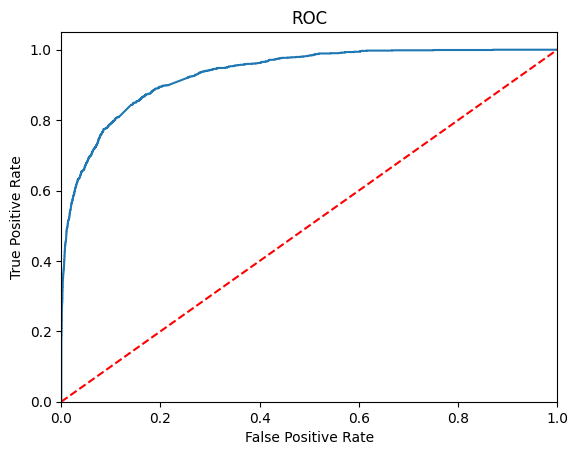

In [26]:
y = train_y
X = x_train_count.astype("float64")

logit_roc_auc = roc_auc_score(y, lgbm_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

## Estimation over test set

In [27]:
test_set.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone see n...
2,safe way heal #acne!! #altwaystoheal #healthy ...
3,"hp cursed child book reservation already? yes,..."
4,"3rd #bihday amazing, hilarious #nephew eli ahm..."


In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test_set["tweet"])
test_set.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
lgbm_model.predict(test_set.astype("float"))[0:5]

array([0, 1, 0, 0, 0])

## Visualization

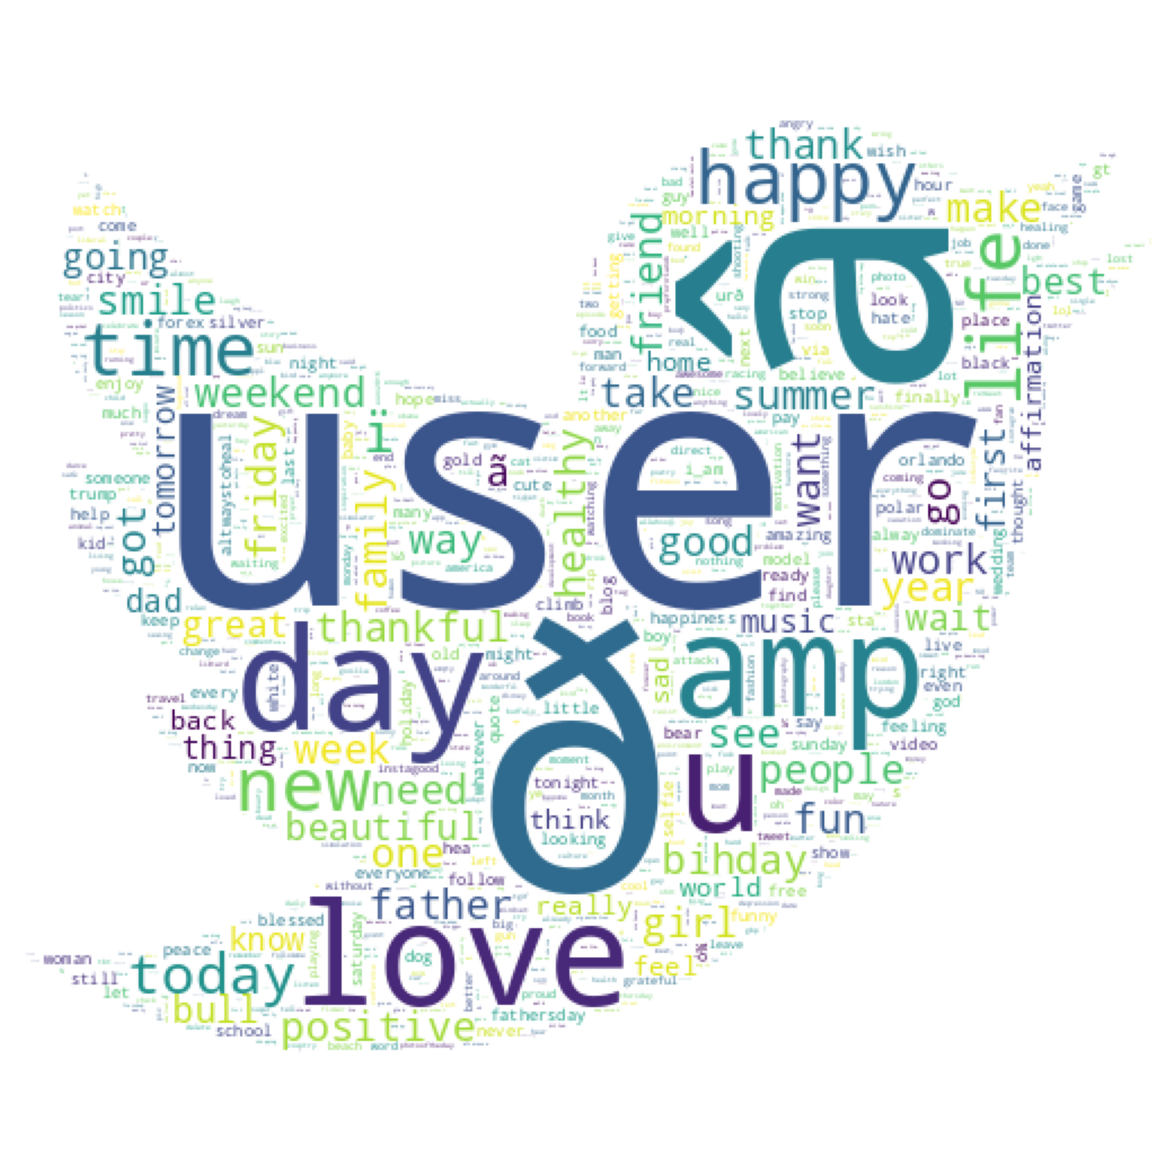

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

tw_mask = np.array(Image.open('twitter_mask3.jpg'))

text = " ".join(i for i in train_set.tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = tw_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.axis("off")
plt.show;